# One-way and two-way ANOVA (Part I)

Throughout the following exercises, you will learn to use Python to run both a one-way and two-way ANOVA test. You'll also learn to run a post hoc test to analyze the results of a one-way ANOVA test. Before starting on this programming exercise, we strongly recommend watching the video lecture and completing the IVQ for the associated topics.



Recall the following definitions:

* **One-way ANOVA:** Compares the means of one continuous dependent variable based on three or more groups of one categorical variable.
* **Two-way ANOVA:** Compares the means of one continuous dependent variable based on three or more groups of two categorical variables.



All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

As we move forward, you can find instructions on how to install required libraries as they arise in this notebook. Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using pandas and statsmodels for operations, and seaborn for plotting.

## Relevant Imports

Begin by importing the relevant packages and data.

In [1]:
# Import pandas and seaborn packages
import pandas as pd
import seaborn as sns

In [2]:
# Load in diamonds data set from seaborn package
diamonds = sns.load_dataset("diamonds", cache=False)

# Examine first 5 rows of data set
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Data cleaning I (not shown in video)

For this part of the course, our main focus is on one-way and two-way ANOVA. This means that our dataset needs a continuous variable, and up to two categorical variables.

**Note:** In the workplace, you will always start with a business problem and the data, and then determine the best models or tests to run on the data. You will *never* work in the reverse. For educational purposes, our goal is to teach you about ANOVA in this notebook and the accompanying resources.

In [3]:
# Check how many diamonds are each color grade
diamonds["color"].value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [4]:
# Subset for colorless diamonds
colorless = diamonds[diamonds["color"].isin(["E","F","H","D","I"])]

# Select only color and price columns, and reset index
colorless = colorless[["color","price"]].reset_index(drop=True)

**Note:** We took a subset of colorless and near colorless diamonds. We excluded G color grade diamonds as there were many more of them, and we excluded J color grade diamonds as there were significantly fewer of them. In a workplace setting, you would typically go through a more thoughtful process of subsetting. The goal of this notebook is focusing on ANOVA, not data cleaning or variable selection.

In [5]:
# Remove dropped categories of diamond color
colorless.color = colorless.color.cat.remove_categories(["G","J"])

# Check that the dropped categories have been removed
colorless["color"].values

['E', 'E', 'E', 'I', 'I', ..., 'D', 'D', 'D', 'H', 'D']
Length: 39840
Categories (5, object): ['D', 'E', 'F', 'H', 'I']

In [6]:
# Import math package
import math

# Take the logarithm of the price, and insert it as the third column
colorless.insert(2, "log_price", [math.log(price) for price in colorless["price"]])

**Note:** The first argument in the `insert()` function allows you to specify the location of the new column with a column number. But the argument starts counting at 0. So if you put in 0, that is the first column; if you enter 1, that is the second column, and so on. Since we specified 2, the new `log_price` column will be the third column.

Next, we use the `dropna()` function to drop the rows with missing values. Setting the `inplace` argument to `True` means that we do not have to save the dataframe as a new variable. Then, we'll reset the index using the `reset_index()` function to reset the index column to account for the rows we just dropped. The `inplace` argument works the same as it did for the `dropna()` function, and the `drop` argument prevents us from creating a new column with the old index numbers preserved.

In [7]:
# Drop rows with missing values
colorless.dropna(inplace=True)

# Reset index
colorless.reset_index(inplace=True, drop=True)

In [8]:
# Examine first 5 rows of cleaned data set
colorless.head()

,color,price,log_price
0,E,326,5.786897
1,E,326,5.786897
2,E,327,5.789960
3,I,334,5.811141
4,I,336,5.817111


In [9]:
# Save to diamonds.csv
colorless.to_csv('diamonds.csv',index=False,header=list(colorless.columns))

**Note:** The code creates a new .csv file of the `colorless` dataframe, and names it `diamonds.csv`. The `index` argument tells the function whether or not we want to save the index column as a column in the .csv file. Additionally, the `header` argument tells the function what the names of the columns should be.

## One-way ANOVA

To run one-way ANOVA, we first load in the data, and save it as a variable called `diamonds`, and then examine it using the `head()` function.

In [10]:
# Save diamonds.csv as a variable called diamonds
diamonds = pd.read_csv("diamonds.csv")

In [11]:
# Examine first 5 rows of diamonds data set
diamonds.head()

,color,price,log_price
0,E,326,5.786897
1,E,326,5.786897
2,E,327,5.789960
3,I,334,5.811141
4,I,336,5.817111


Recall that one-way ANOVA helps us better understand the relationship between a categorical variable and a continuous variable. We'll do some basic exploratory data analysis by creating a boxplot using the `boxplot()` function from the `seaborn` package.

Based on the plot, we can observe that there is a lot of overlap in the distribution of `log_price` for each color of diamond. But we can't tell yet if they are statistically significantly different.

<Axes: xlabel='color', ylabel='log_price'>

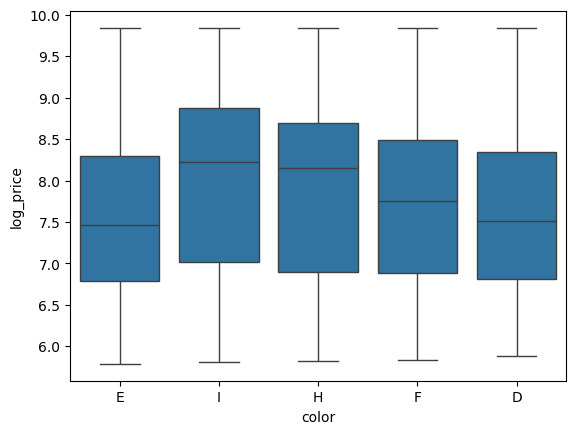

In [12]:
# Create boxplot to show distribution of price by color grade
sns.boxplot(x = "color", y = "log_price", data = diamonds)

In order to run ANOVA, we need to create a regression model. To do this, we'll import the `statsmodels.api` package and the `ols()` function. Next, we'll create a simple linear regression model where the X variable is `color`, which we will code as categorical using `C()`. Then, we'll fit the model to the data, and generate model summary statistics.

In [13]:
# Import statsmodels and ols function
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [14]:
# Construct simple linear regression model, and fit the model
model = ols(formula = "log_price ~ C(color)", data = diamonds).fit()

In [15]:
# Get summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     265.0
Date:                Fri, 10 Jan 2025   Prob (F-statistic):          3.61e-225
Time:                        10:38:18   Log-Likelihood:                -56182.
No. Observations:               39840   AIC:                         1.124e+05
Df Residuals:                   39835   BIC:                         1.124e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.6169      0.012    632.421      0.000       7.593       7.641
C(color)[T.E]    -0.0375      0.016     -2.394      0.017      -0.068      -0.007
C(color)[T.F]     0.1455      0.016      9.240      0.000       0.115       0.176
C(color)[T.H]     0.3015      0.016     18.579      0.000       0.270       0.333
C(color)[T.I]     0.4061      0.018     22.479      0.000       0.371       0.441
==============================================================================
Omnibus:                     7112.992   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1542.881
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                       2.049   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the model summary table, the color grades' associated beta coefficients all have a p-value of less than 0.05 (check the `P>|t|` column). But we can't be sure if there is a significant price difference between the various color grades. This is where one-way ANOVA comes in.

First, we have to state our null and alternative hypotheses:

#### Null Hypothesis

$$H_0: price_D=price_E=price_F=price_H=price_I$$

There is no difference in the price of diamonds based on color grade.

#### Alternative Hypothesis

$$H_1: \text{Not } price_D=price_E=price_F=price_H=price_I$$

There is a difference in the price of diamonds based on color grade.

In [16]:
# Run one-way ANOVA
sm.stats.anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
C(color),1041.690290,4.0,264.987395,3.609774e-225
Residual,39148.779822,39835.0,NaN,NaN


In [17]:
sm.stats.anova_lm(model, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,1041.690290,260.422572,264.987395,3.609774e-225
Residual,39835.0,39148.779822,0.982773,NaN,NaN


In [18]:
sm.stats.anova_lm(model, typ = 3)

,sum_sq,df,F,PR(>F)
Intercept,393066.804852,1.0,399956.684283,0.000000e+00
C(color),1041.690290,4.0,264.987395,3.609774e-225
Residual,39148.779822,39835.0,NaN,NaN


We use the `anova_lm()` function from the `statsmodels.stats` package. As noted previously, the function requires a fitted regression model, and for us to specify the type of ANOVA: 1, 2, or 3. You can review the [statsmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html) to learn more, as well as to [this article](https://www.r-bloggers.com/2011/03/anova-%e2%80%93-type-iiiiii-ss-explained/) and [this explanation on StackExchange](https://stats.stackexchange.com/questions/20452/how-to-interpret-type-i-type-ii-and-type-iii-anova-and-manova). Since the p-value (column `PR(>F)`) is very small, we can reject the null hypothesis that the mean of the price is the same for all diamond color grades. 

**Technical note:** The type of an ANOVA and the number of ways of an ANOVA are two distinct concepts: "type" (`typ` in `statsmodels.stats.anova.anova_lm()`) refers to how the sums of squares (these quantities are the building blocks for ANOVA) are calculated, while "K-way" means that there are K categorical factors in the analysis.

## Data cleaning II (not shown in video)

In this part of the notebook, we will prepare a second dataset so we can perform a two-way ANOVA, which requires two categorical variables. We will start with the same diamonds dataset from the `seaborn` package.

In [19]:
# Import diamonds data set from seaborn package
diamonds = sns.load_dataset("diamonds", cache=False)

In [20]:
# Examine first 5 rows of data set
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Below, we go through a very similar process as above. We start by selecting the columns of interest: `color`, `cut`, and `price`. Then, we subset only for certain color grades, and remove the dropped colors from the list of categories using the `remove_categories()` function.

Next, we subset for specific diamond cuts: `Ideal`, `Premium`, and `Very Good`, and remove the dropped cuts from the list of categories.

Next, we remove rows with missing data, and reset the index.

Lastly, we add in a column for the logarithm of the price.

In [21]:
# Subset for color, cut, price columns
diamonds2 = diamonds[["color","cut","price"]]

# Only include colorless diamonds
diamonds2 = diamonds2[diamonds2["color"].isin(["E","F","H","D","I"])]

# Drop removed colors, G and J
diamonds2.color = diamonds2.color.cat.remove_categories(["G","J"])

# Only include ideal, premium, and very good diamonds
diamonds2 = diamonds2[diamonds2["cut"].isin(["Ideal","Premium","Very Good"])]

# Drop removed cuts
diamonds2.cut = diamonds2.cut.cat.remove_categories(["Good","Fair"])

# Drop NaNs
diamonds2.dropna(inplace = True)

# Reset index
diamonds2.reset_index(inplace = True, drop = True)

# Add column for logarithm of price
diamonds2.insert(3,"log_price",[math.log(price) for price in diamonds2["price"]])

In [22]:
# Examine the data set
diamonds2.head()

,color,cut,price,log_price
0,E,Ideal,326,5.786897
1,E,Premium,326,5.786897
2,I,Premium,334,5.811141
3,I,Very Good,336,5.817111
4,H,Very Good,337,5.820083


We save the dataset as a .csv file again using the `to_csv()` function, just as above.

In [23]:
# Save as diamonds2.csv
diamonds2.to_csv('diamonds2.csv',index=False,header=list(diamonds2.columns))

## Two-Way ANOVA

Now we can load in the dataset we just created using the `read_csv()` function from `pandas`.

In [24]:
# Load the data set
diamonds2 = pd.read_csv("diamonds2.csv")

In [25]:
# Examine the first 5 rows of the data set
diamonds2.head()

,color,cut,price,log_price
0,E,Ideal,326,5.786897
1,E,Premium,326,5.786897
2,I,Premium,334,5.811141
3,I,Very Good,336,5.817111
4,H,Very Good,337,5.820083


Then we'll create a multiple linear regression model using the `ols()` function, fit the model to the data, and get the summary statistics.

**Note:** This regression model includes two categorical X variables: `color` and `cut`, and a variable to account for the interaction between `color` and `cut`. The interaction is denoted using the `:` symbol.

In [26]:
# Construct a multiple linear regression with an interaction term between color and cut
model2 = ols(formula = "log_price ~ C(color) + C(cut) + C(color):C(cut)", data = diamonds2).fit()

In [27]:
# Get summary statistics
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     119.5
Date:                Fri, 10 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:38:18   Log-Likelihood:                -49159.
No. Observations:               34935   AIC:                         9.835e+04
Df Residuals:                   34920   BIC:                         9.847e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.4567      0.019    401.583      0.000       7.420       7.493
C(color)[T.E]                        -0.0056      0.024     -0.231      0.817      -0.053       0.042
C(color)[T.F]                         0.1755      0.024      7.166      0.000       0.128       0.224
C(color)[T.H]                         0.2756      0.026     10.739      0.000       0.225       0.326
C(color)[T.I]                         0.3787      0.028     13.294      0.000       0.323       0.435
C(cut)[T.Premium]                     0.2828      0.031      9.153      0.000       0.222       0.343
C(cut)[T.Very Good]                   0.2295      0.031      7.290      0.000       0.168       0.291
C(color)[T.E]:C(cut)[T.Premium]      -0.0322      0.040     -0.800      0.424      -0.111       0.047
C(color)[T.F]:C(cut)[T.Premium]       0.0313      0.040      0.775      0.438      -0.048       0.110
C(color)[T.H]:C(cut)[T.Premium]       0.0947      0.041      2.308      0.021       0.014       0.175
C(color)[T.I]:C(cut)[T.Premium]       0.0841      0.046      1.832      0.067      -0.006       0.174
C(color)[T.E]:C(cut)[T.Very Good]    -0.0931      0.041     -2.294      0.022      -0.173      -0.014
C(color)[T.F]:C(cut)[T.Very Good]    -0.1013      0.041     -2.459      0.014      -0.182      -0.021
C(color)[T.H]:C(cut)[T.Very Good]    -0.0247      0.043     -0.576      0.564      -0.109       0.059
C(color)[T.I]:C(cut)[T.Very Good]     0.0359      0.048      0.753      0.451      -0.057       0.129
==============================================================================
Omnibus:                     4862.888   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1246.556
Skew:                           0.108   Prob(JB):                    2.06e-271
Kurtosis:                       2.100   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the model summary table, many of the color grades' and cuts' associated beta coefficients have a p-value of less than 0.05 (check the `P>|t|` column). Additionally, some of the interactions also seem statistically significant. We'll use a two-way ANOVA to examine further the relationships between price and the two categories of color grade and cut.

First, we have to state our three pairs of null and alternative hypotheses:

#### **Null Hypothesis (Color)**

$$H_0: price_D=price_E=price_F=price_H=price_I$$

There is no difference in the price of diamonds based on color.

#### **Alternative Hypothesis (Color)**

$$H_1: \text{Not } price_D=price_E=price_F=price_H=price_I$$

There is a difference in the price of diamonds based on color.

#### **Null Hypothesis (Cut)**

$$H_0: price_{Ideal}=price_{Premium}=price_{Very \space Good}$$

There is no difference in the price of diamonds based on cut.

#### **Alternative Hypothesis (Cut)**

$$H_1: \text{Not } price_{Ideal}=price_{Premium}=price_{Very \space Good}$$

There is a difference in the price of diamonds based on cut.

#### **Null Hypothesis (Interaction)**

$$H_0: \text{The effect of color on diamond price is independent of the cut, and vice versa.}$$

#### **Alternative Hypothesis (Interaction)**

$$H_1: \text{There is an interaction effect between color and cut on diamond price.}$$

The syntax for a two-way ANOVA is the same as for a one-way ANOVA. We will continue to use the `anova_lm()` function from `statsmodels.stats`.

In [28]:
# Run two-way ANOVA
sm.stats.anova_lm(model2, typ = 2)

,sum_sq,df,F,PR(>F)
C(color),926.361461,4.0,237.014783,3.481145e-201
C(cut),630.641441,2.0,322.706309,1.348511e-139
C(color):C(cut),27.478611,8.0,3.515279,4.531734e-04
Residual,34120.806577,34920.0,NaN,NaN


In [29]:
sm.stats.anova_lm(model2, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,977.195814,244.298954,250.021037,3.747388e-212
C(cut),2.0,630.641441,315.320721,322.706309,1.348511e-139
C(color):C(cut),8.0,27.478611,3.434826,3.515279,4.531734e-04
Residual,34920.0,34120.806577,0.977114,NaN,NaN


In [30]:
sm.stats.anova_lm(model2, typ = 3)

,sum_sq,df,F,PR(>F)
Intercept,157578.043681,1.0,161268.910012,0.000000e+00
C(color),319.145817,4.0,81.655250,4.134649e-69
C(cut),100.144107,2.0,51.244864,5.987341e-23
C(color):C(cut),27.478611,8.0,3.515279,4.531734e-04
Residual,34120.806577,34920.0,NaN,NaN


Since all of the p-values (column `PR(>F)`) are very small, we can reject all three null hypotheses.

# ANOVA post hoc test (Part II)

This part of the notebook contains all of the code that will be presented in the second part of this section in the course. The focus is on post hoc tests after one-way ANOVA using the `statsmodels` package in Python. 

Recall the following definitions:

* **One-way ANOVA:** Compares the means of one continuous dependent variable based on three or more groups of one categorical variable.
* **Post hoc test:** Performs a pairwise comparison between all available groups while controlling for the error rate.

**Note:** Recall that if we run multiple hypothesis tests all with a 95% confidence level, there is an increasing chance of a false positive, or falsely rejecting the null hypothesis. The post hoc test will control for this, and allows us to run many hypothesis tests while remaining confident with the accuracy of the results. Otherwise, be very careful when running multiple hypothesis tests.

## Relevant Imports

We'll start by importing the `statsmodels` package and the `ols` function so we can construct a simple linear regression model. Next, we load in the dataset from the one-way ANOVA. 

**Note:** Running a post hoc test on two-way ANOVA is a bit more advanced and outside the scope of this program, but feel free to explore that on your own.

In [31]:
# Import statsmodels package and ols function
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [32]:
# Load in the data set from one-way ANOVA
diamonds = pd.read_csv("diamonds.csv")

## One-way ANOVA

Here we follow the same steps as above:
1. Build a simple linear regression model
2. Check the results
3. Run one-way ANOVA

In [33]:
# Construct simple linear regression model, and fit the model
model = ols(formula = "log_price ~ C(color)", data = diamonds).fit()

In [34]:
# Get summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     265.0
Date:                Fri, 10 Jan 2025   Prob (F-statistic):          3.61e-225
Time:                        10:38:18   Log-Likelihood:                -56182.
No. Observations:               39840   AIC:                         1.124e+05
Df Residuals:                   39835   BIC:                         1.124e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.6169      0.012    632.421      0.000       7.593       7.641
C(color)[T.E]    -0.0375      0.016     -2.394      0.017      -0.068      -0.007
C(color)[T.F]     0.1455      0.016      9.240      0.000       0.115       0.176
C(color)[T.H]     0.3015      0.016     18.579      0.000       0.270       0.333
C(color)[T.I]     0.4061      0.018     22.479      0.000       0.371       0.441
==============================================================================
Omnibus:                     7112.992   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1542.881
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                       2.049   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have reconstructed the simple linear regression model, we can re-run the ANOVA.

In [35]:
# Run one-way ANOVA
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(color),1041.690290,4.0,264.987395,3.609774e-225
Residual,39148.779822,39835.0,NaN,NaN


Since the p-value is very small and we can reject the null hypothesis that the mean price is the same for all diamond color grades, we can continue on to run a post hoc test. The post hoc test is useful because the one-way ANOVA does not tell us which colors are associated with different prices. The post hoc test will give us more information.

## Post hoc test

There are many post hoc tests that can be run. One of the most common ANOVA post hoc tests is the **Tukey's HSD (honestly significantly different) test**. We can import the `pairwise_tukeyhsd()` function from the `statsmodels` package to run the test.

In [36]:
# Import Tukey's HSD function
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Then we can run the test. The `endog` variable specifies which variable is being compared across groups, which is `log_price` in this case. Then the `groups` variables indicates which variable holds the groups we're comparing, which is `color`. `alpha` tells the function the significance or confidence level, which we'll set to `0.05`. We'll aim for the typical 95% confidence level.

In [37]:
# Run Tukey's HSD post hoc test for one-way ANOVA
tukey_oneway = pairwise_tukeyhsd(endog = diamonds["log_price"], groups = diamonds["color"], alpha = 0.05)

Lastly, we get the results of the test.

In [38]:
# Get results (pairwise comparisons)
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
D,E,-0.0375,0.1169,-0.0802,0.0052,False
D,F,0.1455,0.0,0.1026,0.1885,True
D,H,0.3015,0.0,0.2573,0.3458,True
D,I,0.4061,0.0,0.3568,0.4553,True
E,F,0.183,0.0,0.1441,0.2219,True
E,H,0.339,0.0,0.2987,0.3794,True
E,I,0.4436,0.0,0.3978,0.4893,True
F,H,0.156,0.0,0.1154,0.1966,True
F,I,0.2605,0.0,0.2145,0.3065,True
H,I,0.1045,0.0,0.0573,0.1517,True


Each row represents a pariwise comparison between the prices of two diamond color grades. The `reject` column tells us which null hypotheses we can reject. Based on the values in that column, we can reject each null hypothesis, except when comparing D and E color diamonds. We cannot reject the null hypothesis that the diamond price of D and E color diamonds are the same.

#### **Test 1: D vs. E**
$H_0: price_D=price_E$

The price of D and E color grade diamonds are the same.

$H_1: price_D \neq price_E$

The price of D and E color grade diamonds are not the same.

**Result:** We *cannot* reject the null hypothesis that the price of D and E color grade diamonds are the same.

#### **Test 2: D vs. F**
$H_0: price_D=price_F$

The price of D and F color grade diamonds are the same.

$H_1: price_D \neq price_F$

The price of D and F color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of D and F color grade diamonds are the same.

#### **Test 3: D vs. H**
$H_0: price_D=price_H$

The price of D and H color grade diamonds are the same.

$H_1: price_D \neq price_H$

The price of D and H color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of D and H color grade diamonds are the same.

#### **Test 4: D vs. I**
$H_0: price_D=price_I$

The price of D and I color grade diamonds are the same.

$H_1: price_D \neq price_I$

The price of D and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of D and I color grade diamonds are the same.

#### **Test 5: E vs. F**
$H_0: price_E=price_F$

The price of E and F color grade diamonds are the same.

$H_1: price_E \neq price_F$

The price of E and F color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of E and F color grade diamonds are the same.

#### **Test 6: E vs. H**
$H_0: price_E=price_H$

The price of E and H color grade diamonds are the same.

$H_1: price_E \neq price_H$

The price of E and H color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of E and H color grade diamonds are the same.

#### **Test 7: E vs. I**
$H_0: price_E=price_I$

The price of E and I color grade diamonds are the same.

$H_1: price_E \neq price_I$

The price of E and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of E and I color grade diamonds are the same.

#### **Test 8: F vs. H**
$H_0: price_F=price_H$

The price of F and H color grade diamonds are the same.

$H_1: price_F \neq price_H$

The price of F and H color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of F and H color grade diamonds are the same.

#### **Test 9: F vs. I**
$H_0: price_F=price_I$

The price of F and I color grade diamonds are the same.

$H_1: price_F \neq price_I$

The price of F and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of F and I color grade diamonds are the same.

#### **Test 10: H vs. I**
$H_0: price_H=price_I$

The price of H and I color grade diamonds are the same.

$H_1: price_H \neq price_I$

The price of H and I color grade diamonds are not the same.

**Result:** We *can* reject the null hypothesis that the price of H and I color grade diamonds are the same.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.

You now understand how to run a one-way and two-way ANOVA test with Python. Going forward, you can start using one-way and two-way ANOVA tests with your own datasets.